## CNN Demo Notebook

In this notebook we show how the CNN component in our project is trained and evaluated on smaller, stationary, anisotropic spatial data. 

This notebook is nearly identical to the `i2i_demo.ipynb` notebook. 
For more details and guidance, please visit that notebook.

In [1]:
# imports required for CNN
import time
import torch
from torch.utils.data import DataLoader

from latticevision.device import set_device
from latticevision.plotting import plot_example_field, plot_losses

from latticevision.cnn.dataset import make_dataset, DataConfig
from latticevision.cnn.model import ModelConfig, CNN
from latticevision.cnn.train import TrainingConfig, train_model
from latticevision.cnn.eval import eval_model

# imports required for local CNN estimation on I2I data
from latticevision.img2img.dataset import make_dataset as make_img2img_dataset
from latticevision.img2img.dataset import DataConfig as Img2ImgDataConfig
from latticevision.cnn.eval import fast_cnn_field_tiler
from latticevision.plotting import plot_img2img_samples
from latticevision.img2img.eval import eval_model as eval_img2img_model
from latticevision.seed import set_all_random_seeds

ImportError: 
        torchao not installed.
        Please follow the instructions at https://pytorch.org/torchtune/main/install.html#pre-requisites
        to install torchao.
        

In [2]:
# set random seed for reproducibility
set_all_random_seeds(777)

device = set_device(machine="remote", gpu=True, gpu_id="cuda:0", verbose=True)

Using device: cuda:0 
Hardware:  NVIDIA RTX A6000


In [3]:
# dataset_path = "../sample_data/CNN_test_data.h5"
# val_size = 0.4
# test_size = 0.5

dataset_path = "../data/CNN_data.h5"
val_size = 0.1
test_size = 0.2

data_config = DataConfig(
	file_path=dataset_path,
	fullsidelen=25,
	sidelen=25,
	n_replicates=30,
	n_params=3,
	log_kappa2=True,
	val_size=val_size,
	test_size=test_size,
	random_state=777,
	verbose=True,
)

data_dict = make_dataset(data_config)

train_df = data_dict["train_df"]
val_df = data_dict["val_df"]
test_df = data_dict["test_df"]

Components in the file: ['fields']
Dataset size (MB):  11825.561660766602
Dataset size (GB):  11.548400059342384
Dims of 'fields': (80000, 30, 25, 25)
Dims of 'params': (80000, 3)
Train fields shape:  (72000, 30, 25, 25)
Train params shape:  (72000, 3)
Validation fields shape:  (6400, 30, 25, 25)
Validation params shape:  (6400, 3)
Test fields shape:  (1600, 30, 25, 25)
Test params shape:  (1600, 3)


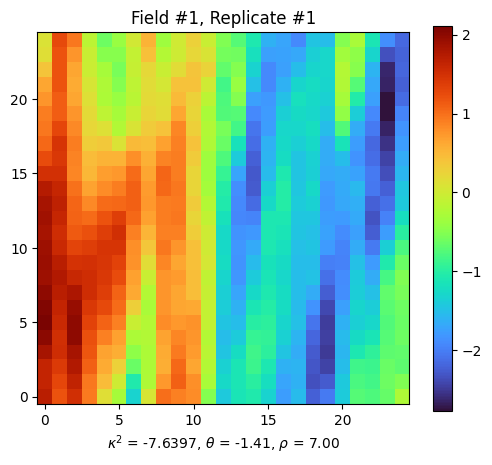

In [4]:
plot_example_field(
	dataset=train_df,
	config=data_config,
	idx=0,
	model_type="CNN",
	field_color="turbo",
)

In [5]:
n_batch = 64

train_loader = DataLoader(train_df, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_df, batch_size=n_batch, shuffle=False)
test_loader = DataLoader(test_df, batch_size=n_batch, shuffle=False)

for fields, params in train_loader:
	print("Train Loader:")
	print("Fields batch shape: ", fields.shape, "\nParams batch shape: ", params.shape)
	break

for fields, params in val_loader:
	print("Validation Loader:")
	print("Fields batch shape: ", fields.shape, "\nParams batch shape: ", params.shape)
	break

for fields, params in test_loader:
	print("Test Loader:")
	print("Fields batch shape: ", fields.shape, "\nParams batch shape: ", params.shape)
	break

Train Loader:
Fields batch shape:  torch.Size([64, 30, 25, 25]) 
Params batch shape:  torch.Size([64, 3])
Validation Loader:
Fields batch shape:  torch.Size([64, 30, 25, 25]) 
Params batch shape:  torch.Size([64, 3])
Test Loader:
Fields batch shape:  torch.Size([64, 30, 25, 25]) 
Params batch shape:  torch.Size([64, 3])


In [6]:
config = ModelConfig(
	sidelen=25,
	in_channels=30,
	out_params=3,
	conv_channels=(64, 128, 256),
	linear_sizes=(500, 64),
	kernel_sizes=(10, 7, 5),
	padding=0,
)

# config = ModelConfig(
#     sidelen=17,
# 	in_channels=30,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (6,4,4),
#     padding = 0,
# )

# config = ModelConfig(
#     sidelen=9,
# 	in_channels=30,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (2,2,2),
#     padding = 0,
# )

model = CNN(config).to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 2597815


In [7]:
start_time = time.time()

train_config = TrainingConfig(
	model=model,
	device=device,
	train_loader=train_loader,
	val_loader=val_loader,
	train_df=train_df,
	val_df=val_df,
	lr=1e-4,
	n_epochs=20,
	stop_patience=10,
	scheduler_patience=5,
	scheduler_factor=0.5,
	augmentation=False,
	save=False,  # switch to True to save model after training, currently this is just training for show
	save_directory="../results/model_wghts/",
	savename="cnn_wghts25_example.pth",
	verbose=True,
	normalize=True,
	shuffle=True,
)

training_results = train_model(config=train_config)

time_train = time.time() - start_time
print("Training took: ", time_train / 60, " minutes.")

model = training_results["model"]
train_losses = training_results["train_losses"]
val_losses = training_results["val_losses"]

Training for 20 epochs with learning rate 0.0001.
Model weights will not be saved.
Augmentation has been disabled.
Normalization has been enabled.
Shuffling has been enabled.
Epoch 1/20
Train Loss: 2.260785 - Val Loss: 2.066091
Learning Rate: 0.000100
Epoch 2/20
Train Loss: 2.003645 - Val Loss: 1.796224
Learning Rate: 0.000100
Epoch 3/20
Train Loss: 1.413147 - Val Loss: 1.235450
Learning Rate: 0.000100
Epoch 4/20
Train Loss: 1.140063 - Val Loss: 1.072334
Learning Rate: 0.000100
Epoch 5/20
Train Loss: 0.964774 - Val Loss: 0.927715
Learning Rate: 0.000100
Epoch 6/20
Train Loss: 0.814381 - Val Loss: 0.776340
Learning Rate: 0.000100
Epoch 7/20
Train Loss: 0.737055 - Val Loss: 0.685451
Learning Rate: 0.000100
Epoch 8/20
Train Loss: 0.690782 - Val Loss: 0.677936
Learning Rate: 0.000100
Epoch 9/20
Train Loss: 0.657447 - Val Loss: 0.614216
Learning Rate: 0.000100
Epoch 10/20
Train Loss: 0.630879 - Val Loss: 0.601640
Learning Rate: 0.000100
Epoch 11/20
Train Loss: 0.609231 - Val Loss: 0.573998


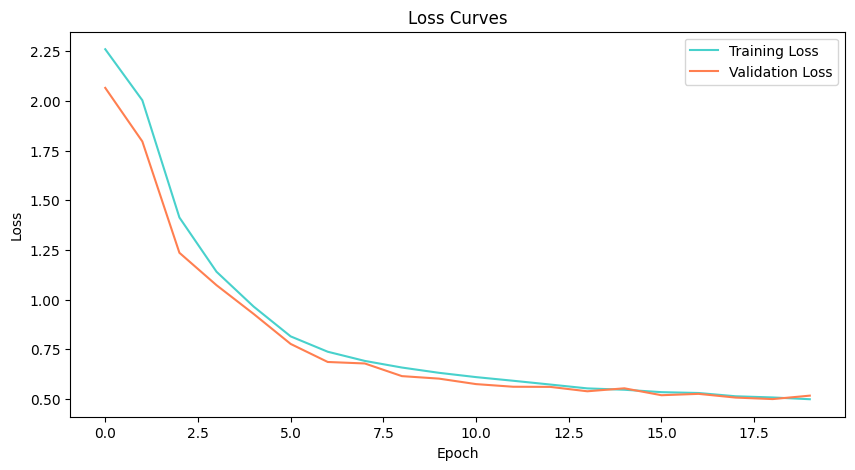

In [8]:
plot_losses(train_losses=train_losses, val_losses=val_losses)

In [9]:
config = ModelConfig(
	sidelen=25,
	in_channels=30,
	out_params=3,
	conv_channels=(64, 128, 256),
	linear_sizes=(500, 64),
	kernel_sizes=(10, 7, 5),
	padding=0,
)

# config = ModelConfig(
#     sidelen=17,
# 	in_channels=30,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (6,4,4),
#     padding = 0,
# )

# config = ModelConfig(
#     sidelen=9,
# 	in_channels=30,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (2,2,2),
#     padding = 0,
# )

# model = CNN(config)
# state_dict = torch.load(
# 	"../results/model_wghts/cnn_wghts25_ex.pth", map_location=torch.device(device)
# )
# model.load_state_dict(state_dict)
# model.to(device)

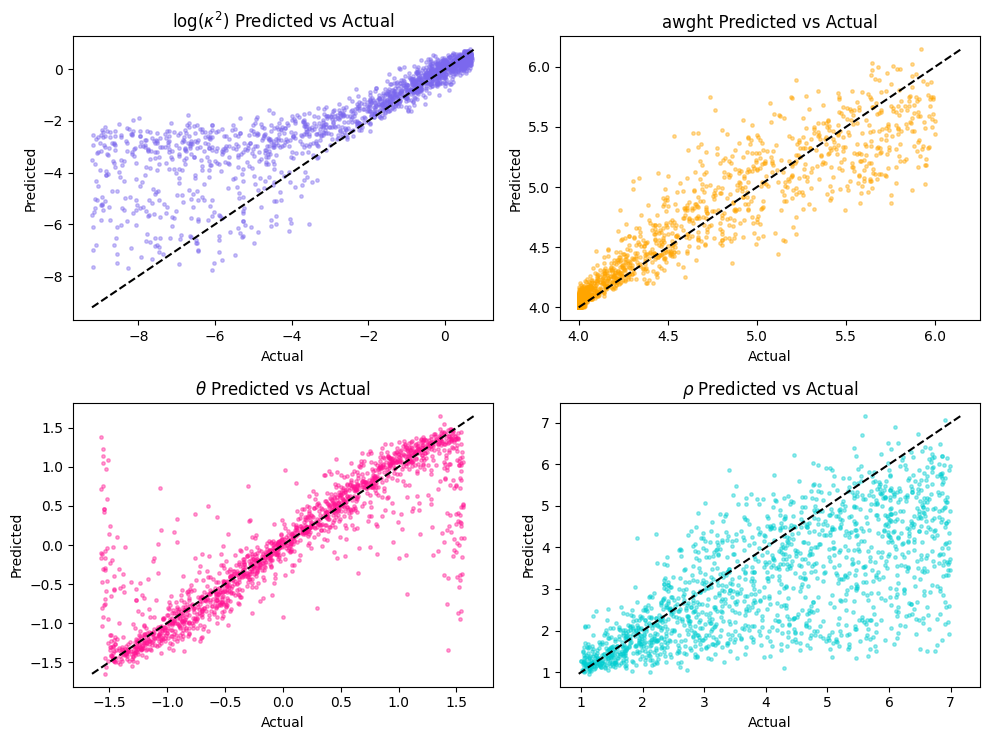

               rmse       mae        r2     nrmse
parameter                                        
kappa2     1.904573  1.155879  0.589727  0.192313
theta      0.444746  0.233922  0.755830  0.141665
rho        1.551817  1.120130  0.237911  0.258937


In [10]:
metrics = eval_model(
	model=model,
	device=device,
	config=data_config,
	test_loader=test_loader,
	test_df=test_df,
	plot=True,
	augmentation=True,
)

### Local estimation on large image to image data 

We tile up our images and take a moving-window approach to local estimation, returning the same metrics and images as we do with our large vision models:


In [11]:
# for testing
# dataset_path_i2i = "../sample_data/STUN_test_data.h5"
# val_size_i2i = 0.4
# test_size_i2i = 0.5

dataset_path_i2i = "../data/STUN_data.h5"
val_size_i2i = 0.1
test_size_i2i = 0.2

data_config_i2i = Img2ImgDataConfig(
	file_path=dataset_path_i2i,
	n_rows=192,
	n_cols=288,
	n_replicates=30,
	n_params=3,
	log_kappa2=True,
	shift_theta=True,
	val_size=val_size_i2i,
	test_size=test_size_i2i,
	random_state=777,
	verbose=True,
)

data_dict = make_img2img_dataset(
	config=data_config_i2i,
)

test_df_i2i = data_dict["test_df"]

del data_dict

n_batch = 64
# make loader and df are in same order for eval funcs
test_loader_i2i = DataLoader(test_df_i2i, batch_size=n_batch, shuffle=False)
for fields, params in test_loader_i2i:
	print("Test Loader:")
	print("Fields batch shape: ", fields.shape, "\nParams batch shape: ", params.shape)
	break

Components in the file: ['fields']
Dataset size (MB):  111375.0001373291
Dataset size (GB):  108.76464857161045
Fields shape:  (8000, 30, 192, 288)
Params shape:  (8000, 3, 192, 288)
Train fields shape:  (7200, 30, 192, 288)
Train params shape:  (7200, 3, 192, 288)
Validation fields shape:  (640, 30, 192, 288)
Validation params shape:  (640, 3, 192, 288)
Test fields shape:  (160, 30, 192, 288)
Test params shape:  (160, 3, 192, 288)
Test Loader:
Fields batch shape:  torch.Size([64, 30, 192, 288]) 
Params batch shape:  torch.Size([64, 3, 192, 288])


In [12]:
test_fields = test_df_i2i[:][0]
test_params = test_df_i2i[:][1]

print("Test fields shape: ", test_fields.shape)
print("Test params shape: ", test_params.shape)

outputs = torch.zeros(test_params.size())

Test fields shape:  torch.Size([160, 30, 192, 288])
Test params shape:  torch.Size([160, 3, 192, 288])


In [13]:
# fast option
for i in range(len(outputs)):
	output = fast_cnn_field_tiler(
		model=model,
		fields=test_fields[i].unsqueeze(0),
		device=device,
		patch_batch_size=10000,
		verbose=False,
		padding_mode="reflect",
		patch_size=25,
	)
	outputs[i] = output

# much slower option
# for i in range(len(outputs)):
#     output = slow_cnn_field_tiler(
#         model = model,
#         fields = test_fields[i].unsqueeze(0),
#         device = device,
#         padding_mode = "reflect",
#         verbose = True,
#         patch_size = 25,
#     )
#     outputs[i] = output

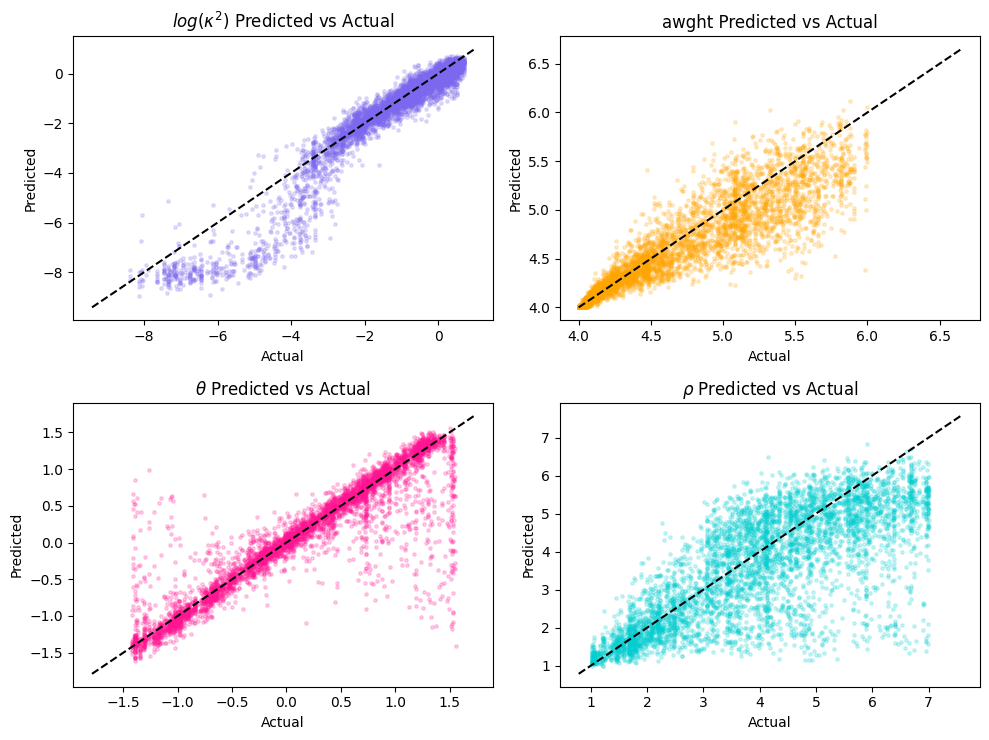

               rmse       mae        r2      ssim      psnr     nrmse
parameter                                                            
kappa2     0.730197  0.447771  0.844047  0.157815  7.259963  0.073731
theta      0.351180  0.168313  0.813846  0.280041  9.089493  0.117423
rho        1.178673  0.836808  0.446925  0.094042  1.608373  0.196475


In [14]:
metrics = eval_img2img_model(
	model=model,
	config=data_config_i2i,
	device=device,
	test_loader=test_loader_i2i,
	test_df=test_df_i2i,
	plot=True,
	augmentation=False,
	n_pixels=5000,
	show=True,
	cnn_mode=True,
	cnn_results=outputs,
)

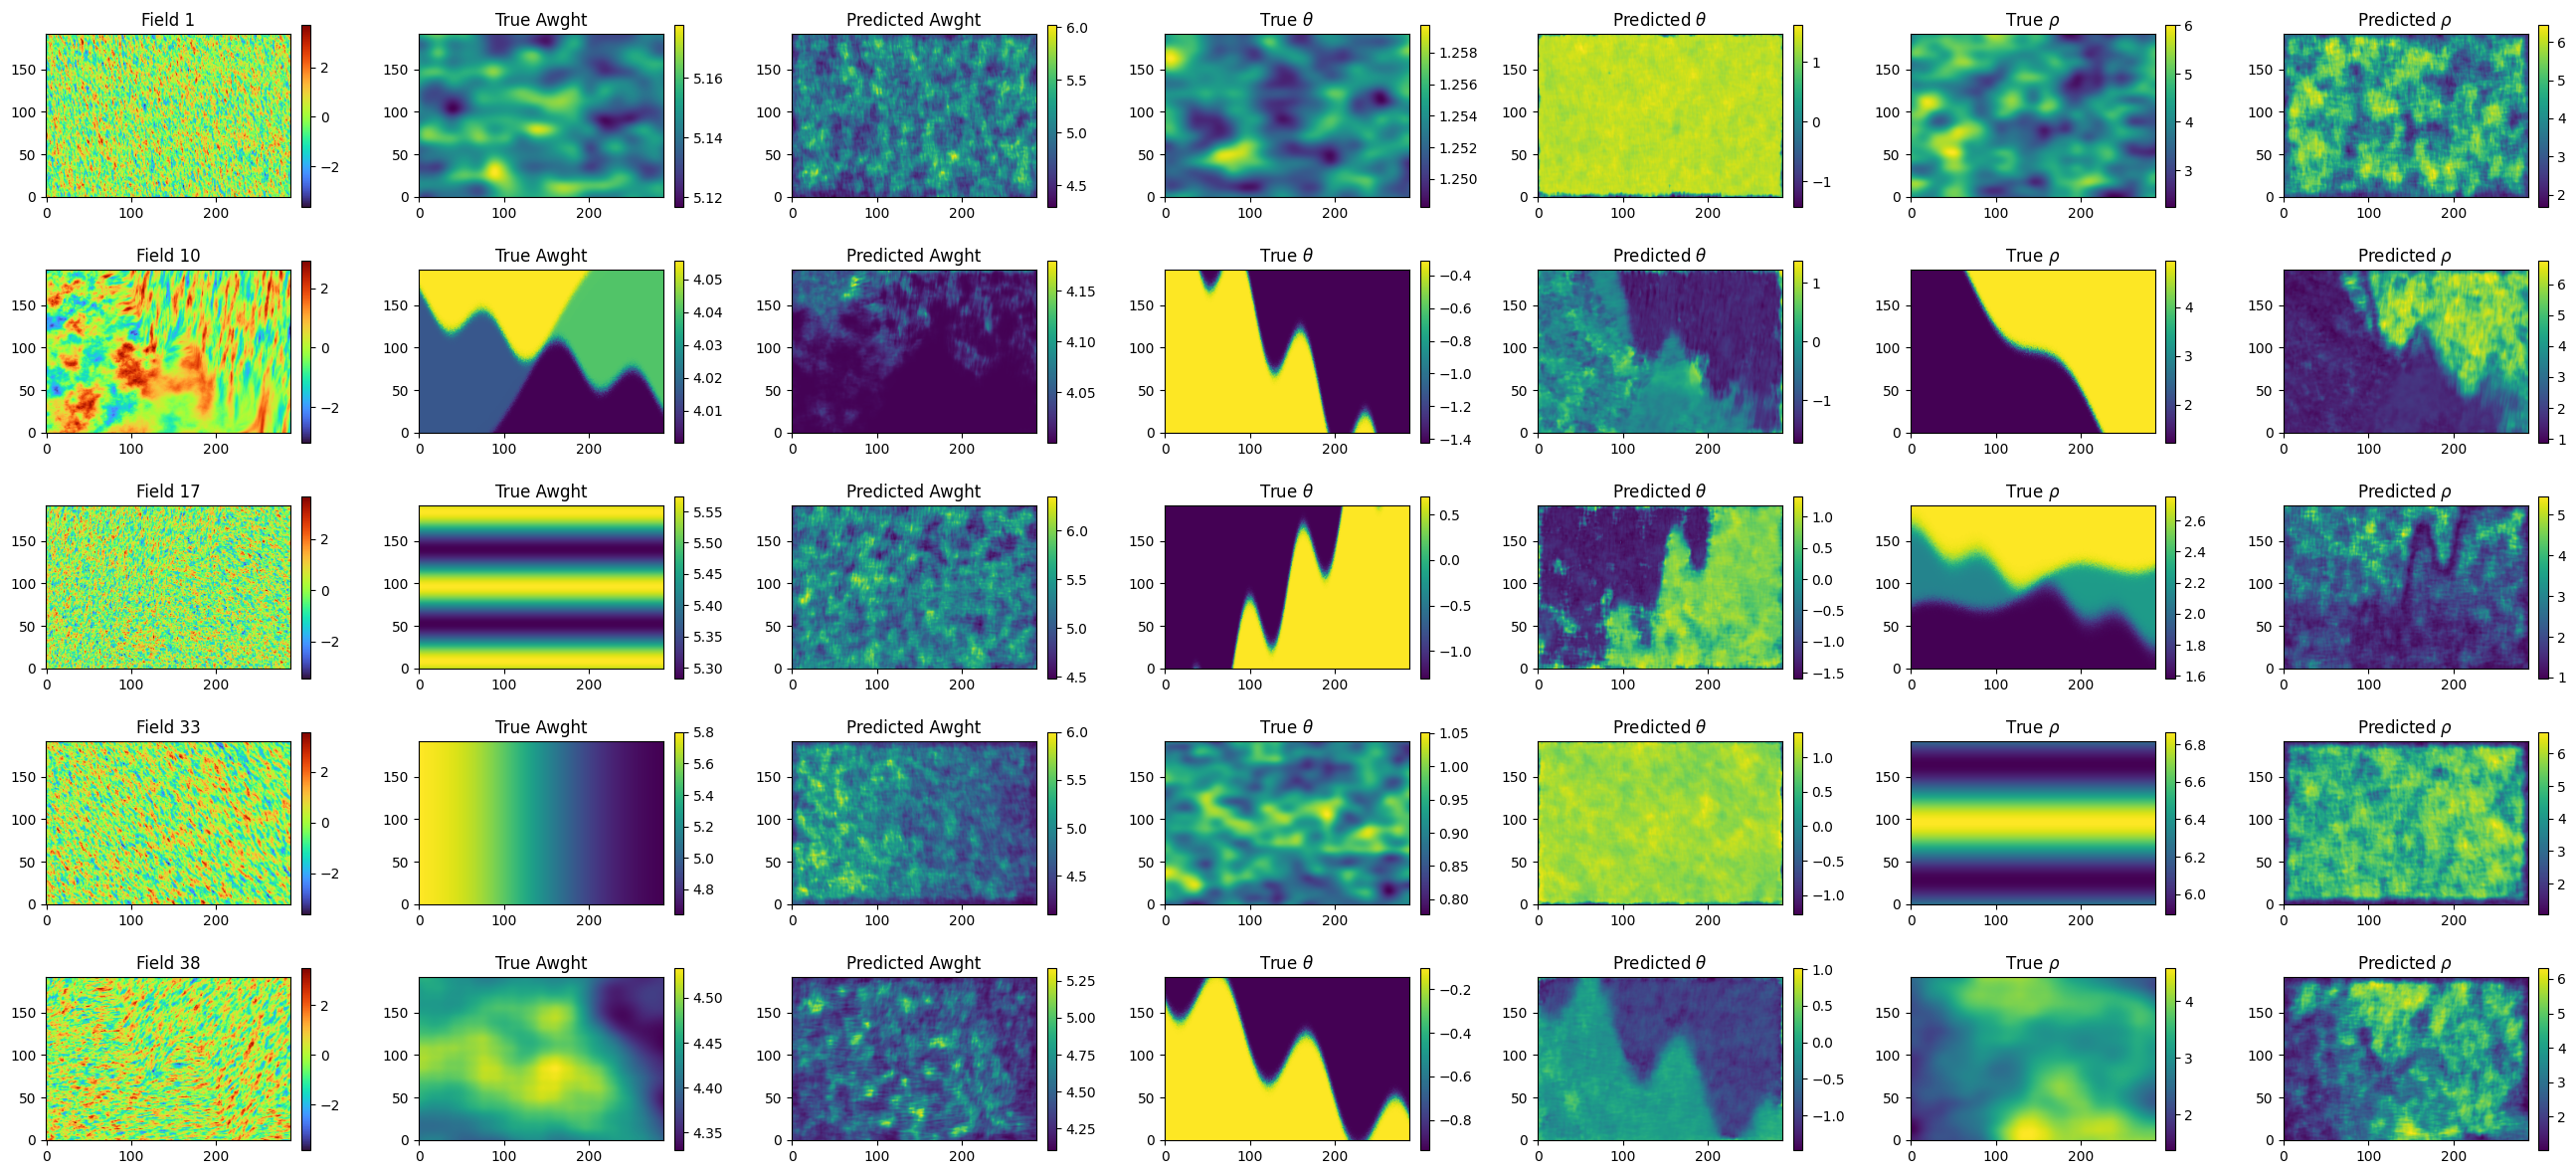

In [15]:
inds = [0, 9, 16, 32, 37]
# inds = [0] # for test dataset

plot_img2img_samples(
	model=model,
	config=data_config_i2i,
	device=device,
	test_df=test_df_i2i,
	indices=inds,
	random_selection=False,
	num_rand_samples=5,
	awght_not_kappa2=True,
	show=True,
	cnn_mode=True,
	cnn_results=outputs,
)